# Problem Statement

This case requires trainees to develop a model for predicting fraudulent transactions for a
financial company and use insights from the model to develop an actionable plan. Data for the
case is available in CSV format having 6362620 rows and 10 columns.

# Data Key

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This Step can be Skipped if you are not using Google Colab Environment

#### Importing the Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import joblib


#### Importing the csv file

In [3]:
file_path = '/content/drive/MyDrive/Fraud Detection/Fraud.csv'
df = pd.read_csv(file_path)


#### Taking an overview of the Dataset

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.shape

(6362620, 11)

In [6]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

# Data Pre-Processing and Feature Extraction

In [7]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Print the count of missing values in each column
print('Missing values:')
print(missing_values)


Missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


This means that there are no missing values in the dataset that needs be taken care of.

I will create a feature "type1" which is a categorical variable with levels "CC" (Customer to Customer), "CM" (Customer to Merchant), "MC" (Merchant to Customer), "MM" (Merchant to Merchant).
In the next few code cells, I seek to compare valid transactions against fraud transactions instead of overall trends.
This is because I want to see patterns that differentiate fraud transactions from valid ones.

In [8]:
df['type1'] = np.nan  # Initializing the feature column

# Filling the feature column based on nameOrig and nameDest values
df.loc[df['nameOrig'].str.contains('C') & df['nameDest'].str.contains('C'), 'type1'] = 'CC'
df.loc[df['nameOrig'].str.contains('C') & df['nameDest'].str.contains('M'), 'type1'] = 'CM'
df.loc[df['nameOrig'].str.contains('M') & df['nameDest'].str.contains('C'), 'type1'] = 'MC'
df.loc[df['nameOrig'].str.contains('M') & df['nameDest'].str.contains('M'), 'type1'] = 'MM'


In [9]:
# Subsetting data into observations with fraud and valid transactions
fraud = df[df['isFraud'] == 1]
valid = df[df['isFraud'] == 0]


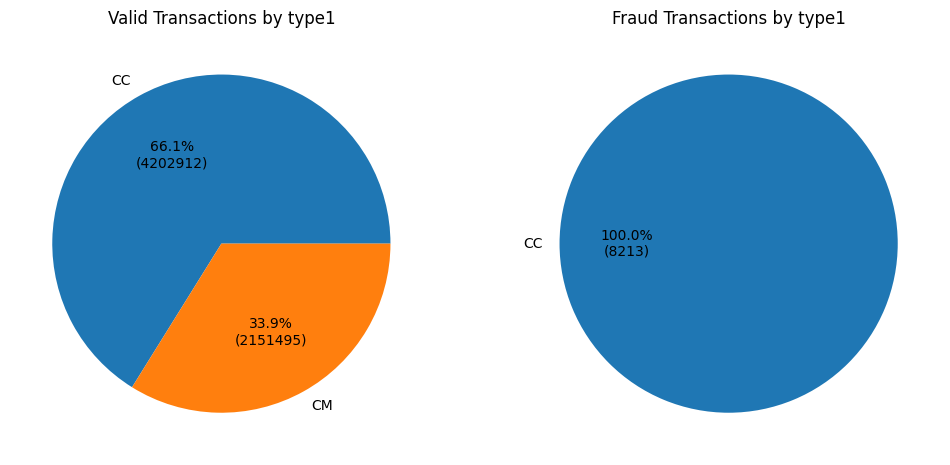

In [10]:
# Counting transactions by 'type1' for fraud transactions
fraud_type_counts = fraud['type1'].value_counts()

# Counting transactions by 'type1' for valid transactions
valid_type_counts = valid['type1'].value_counts()

# Plotting the counts of fraud and valid transactions by 'type1' using pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for valid transactions
axes[0].pie(valid_type_counts, labels=valid_type_counts.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(valid_type_counts))})")
axes[0].set_title('Valid Transactions by type1')

# Pie chart for fraud transactions
axes[1].pie(fraud_type_counts, labels=fraud_type_counts.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(fraud_type_counts))})")
axes[1].set_title('Fraud Transactions by type1')

plt.show()


From the dataset, it seems that fraud transactions only occur when the transaction type1 is CC (Customer to Customer)
This also means that the datasets fraud and valid don't need to be subsetted. However, since all relevant observations have type1 = "CC", the type1 column is no longer necessary and hence will be dropped from the dataset before training the model

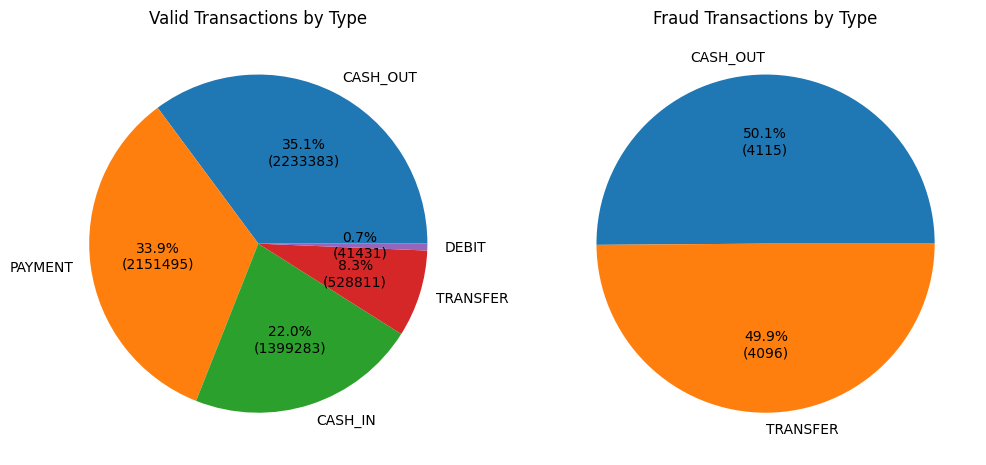

In [11]:
import matplotlib.pyplot as plt

# Counting transactions by 'type' for fraud transactions
fraud_type_counts = fraud['type'].value_counts()

# Counting transactions by 'type' for valid transactions
valid_type_counts = valid['type'].value_counts()

# Plotting the counts of fraud and valid transactions by 'type' using pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for valid transactions
axes[0].pie(valid_type_counts, labels=valid_type_counts.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(valid_type_counts))})")
axes[0].set_title('Valid Transactions by Type')

# Pie chart for fraud transactions
axes[1].pie(fraud_type_counts, labels=fraud_type_counts.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(fraud_type_counts))})")
axes[1].set_title('Fraud Transactions by Type')

plt.show()


This concludes that Fraud transactions are only happening in Transfer and Cash_out transactions

In [12]:
# Counting the transactions that should have been flagged
flagged_transactions = df[(df['amount'] > 200000)]

# Counting the number of flagged transactions that should have been flagged
num_correctly_flagged = flagged_transactions['isFraud'].sum()

#counting the percentage of transactions that were flagged succesfully
percentage_flagged = (num_correctly_flagged / len(df[df['amount'] > 200000])) * 100

# Printing the number of transactions that should have been flagged and were actually flagged
print("Number of transactions that should have been flagged:", len(flagged_transactions))
print("Number of transactions that should have been flagged and were actually flagged:", num_correctly_flagged)
print("Percentage of transactions flagged succesfully", percentage_flagged )

Number of transactions that should have been flagged: 1673570
Number of transactions that should have been flagged and were actually flagged: 5471
Percentage of transactions flagged succesfully 0.3269059555321857


The number of transactions that should have been flagged far exceeds the number of observations that were actually flagged.
In addition, I am trying to develop a new fraud detection screen that does not depend on a pre-existing fraud detection scheme.
For that reason, I am omitting the isFlaggedFraud column from the analysis.

In [13]:
# Count the number of cases where amount == oldbalanceOrg and isFraud == 1
cases_count = df[(df['amount'] == df['oldbalanceOrg']) & (df['isFraud'] == 1)].shape[0]

# Count the total number of cases where amount == oldbalanceOrg
total_cases = df[df['amount'] == df['oldbalanceOrg']].shape[0]

# Print the result
print("Number of cases where amount == oldbalanceOrg and are fraud:", cases_count)
print("Total number of cases where amount == oldbalanceOrg:", total_cases)


Number of cases where amount == oldbalanceOrg and are fraud: 8034
Total number of cases where amount == oldbalanceOrg: 8034


This shows that in every transaction where oldbalanceOrig is equal to amount the transaction is a fraud one. This is happening because all the transactions which are detected as fraud are cancelled, so for fraud detection those 2 columns must not be used.




In [14]:
# separating transfers and cashouts for fraud accounts

fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]

# checking if the recipient account of a fraudulent transfer was used as a sending account for cashing out
fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

False

Thus in this dataset, for fraudulent transactions, the account that received funds during a transfer was not used at all for cashing out.

If that is the case, there seems to be no use for nameOrig or nameDest since there seems to be no restrictions on which accounts cashout from fraudulent transactions.
Thus, I am omitting the nameOrig and nameDest columns from analysis.

In [15]:
# Create dummy variables for the 'type' column
df = pd.get_dummies(df, columns=['type'], prefix='type')


In [16]:
# dropping the columns for the dataset that will not be used to train the model
df = df.drop(['isFlaggedFraud', 'nameOrig', 'nameDest', 'amount', 'oldbalanceOrg','type1'], axis=1)

In [17]:
# Count the number of transactions for each class
class_counts = df['isFraud'].value_counts()

# Calculate the percentage of each class
class_percentages = class_counts / len(df) * 100

# Print the class counts and percentages
print("Class Counts:")
for class_label, count in class_counts.items():
    print(f"{class_label}: {count}")

print("\nClass Percentages:")
for class_label, percentage in class_percentages.items():
    print(f"{class_label}: {percentage:.2f}%")


Class Counts:
0: 6354407
1: 8213

Class Percentages:
0: 99.87%
1: 0.13%


In [18]:
# Set the random state and seed values
random_state = 42
np.random.seed(21)

# Splitting the dataset into train and test sets
X = df.drop('isFraud', axis=1)  # Features (excluding the target variable)
y = df['isFraud']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Printing the shapes of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Train set shape: (5090096, 9) (5090096,)
Test set shape: (1272524, 9) (1272524,)


### Normalizing the data

In [19]:
# Create the MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the training data
X_train_normalized = scaler.fit_transform(X_train)

# Normalize the testing data
X_test_normalized = scaler.transform(X_test)

# Model Training and Evaluation

### Logisitic Regression Model

In [20]:
# Create the Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_normalized, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test_normalized)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy report
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9987308687301772
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       1.00      0.00      0.01      1620

    accuracy                           1.00   1272524
   macro avg       1.00      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



Confusion Matrix:
[[1270904       0]
 [   1615       5]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       1.00      0.00      0.01      1620

    accuracy                           1.00   1272524
   macro avg       1.00      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524

AUC-ROC Score: 0.5015432098765432


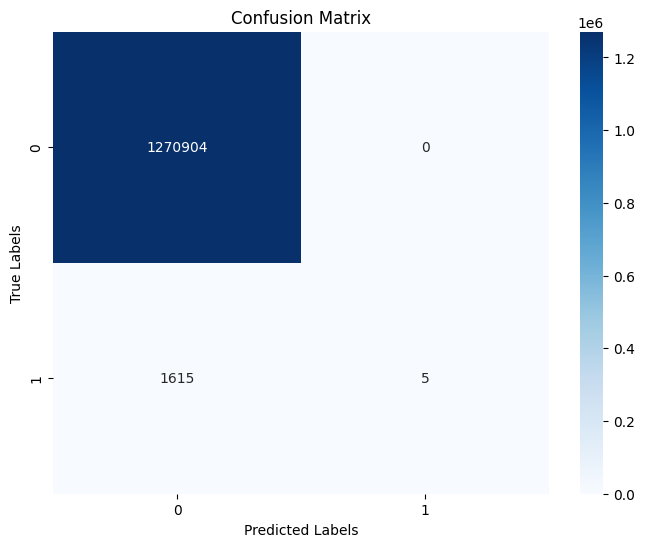

In [21]:
# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred)
print("AUC-ROC Score:", auc_roc)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Summary of Observations from Logistic Regression

Confusion Matrix:
[[1270904 0]
[ 1615 5]]

In the confusion matrix, we have two classes: 0 and 1. Class 0 represents the negative class, while class 1 represents the positive class. The matrix is organized as follows:

True negatives (TN): 1,270,904
False positives (FP): 0
False negatives (FN): 1,615
True positives (TP): 5

From the provided information, we can see that the model performs extremely well in predicting class 0, as indicated by high precision, recall, and F1-score. However, it performs poorly in predicting class 1, as the recall is very low. This suggests that the model struggles to identify positive instances correctly.

An AUC-ROC of 0.5 suggests that the model is unable to distinguish between the positive and negative classes and its predictions are essentially random.


In [22]:
# Create the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the model on the normalized training data
rf_classifier.fit(X_train_normalized, y_train)

# Predict the labels for the normalized testing data
y_pred = rf_classifier.predict(X_test_normalized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9995182802053242


Confusion Matrix:
[[1270869      35]
 [    578    1042]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.64      0.77      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.82      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524

AUC-ROC Score: 0.8215911685454886


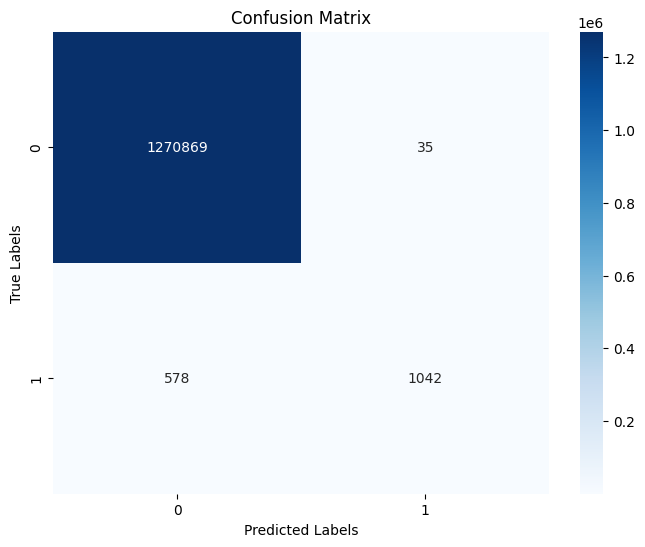

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred)
print("AUC-ROC Score:", auc_roc)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Summary of Accuracy of the Random Forest Model

Confusion Matrix:
[[1270869 35]
[ 578 1042]]

In the confusion matrix, we have two classes: 0 and 1. Class 0 represents the negative class, while class 1 represents the positive class. The matrix is organized as follows:

True negatives (TN): 1,270,869
False positives (FP): 35
False negatives (FN): 578
True positives (TP): 1,042

The F1-score for class 0 remains high, indicating a good balance between precision and recall for the negative class. The F1-score for class 1 also improved, suggesting a better trade-off between precision and recall for the positive class compared to the previous scenario.

The AUC-ROC score of 0.8216 suggests that the model's ability to distinguish between the two classes has improved. However, there is still room for improvement, as an ideal AUC-ROC score is 1.0.

In [24]:

# Get feature importances
importances = rf_classifier.feature_importances_

# Create a list of feature names
feature_names = list(X_train.columns)

# Sort feature importances and corresponding feature names in descending order
feature_importances = sorted(zip(importances, feature_names), reverse=True)

# Print feature importance rankings
print("Feature Importance Rankings:")
for i, (importance, feature) in enumerate(feature_importances):
    print(f"{i + 1}. {feature}: {importance}")


Feature Importance Rankings:
1. newbalanceDest: 0.5486964648300151
2. oldbalanceDest: 0.20458362941761238
3. step: 0.20020848956110907
4. type_TRANSFER: 0.019039177282321122
5. type_CASH_IN: 0.011596242363244495
6. newbalanceOrig: 0.010156099784700424
7. type_PAYMENT: 0.002977139631942822
8. type_CASH_OUT: 0.0026537583029237746
9. type_DEBIT: 8.8998826130918e-05


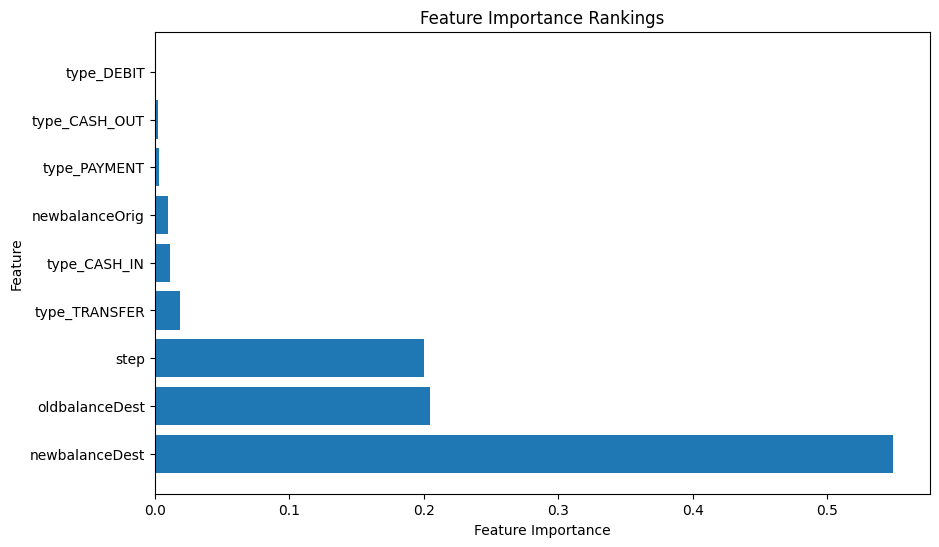

In [25]:
# Extract feature names and importances separately
importance_values = [importance for importance, _ in feature_importances]
feature_names_sorted = [feature for _, feature in feature_importances]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names_sorted)), importance_values, align='center')
plt.yticks(range(len(feature_names_sorted)), feature_names_sorted)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Rankings')
plt.show()


# Final Observations

Among both the Models Random Forest is clearly producing better results but there is still scope for further improvement.



### What are the key factors that predict fraudulent customers?
Key factors that can predict fraudulent customers include the type of transaction, the new and old balances of destination accounts, and the type of account that the money is transferred into.

### Do these factors make sense? If yes, how? If not, why not?
Yes, these factors make sense in the context of fraud detection. The type of transaction is important because different types of transactions may have different levels of risk associated with them. For example, certain transaction types, such as transfers or cash-outs, may be more commonly associated with fraudulent activities.

The new and old balances of destination accounts are relevant because sudden changes or discrepancies in these balances could indicate potential fraudulent behavior. Unusual or abnormal balances in destination accounts after a transaction may suggest fraudulent activity.

The type of account that the money is transferred into is also important to consider. Some account types may be more prone to fraudulent activities, while others may be less likely to be involved in fraudulent transactions.

### What kind of prevention should be adopted while the company updates its infrastructure?
When updating its infrastructure, the company should consider implementing several prevention measures to enhance fraud detection. These measures include advanced anomaly detection using machine learning and statistical techniques, real-time monitoring systems for prompt detection and response to suspicious activities, user behavior analysis to identify potential fraudulent activities, stronger authentication mechanisms like two-factor authentication, data encryption to protect sensitive information, regular employee training on fraud prevention and detection, and conducting regular audits to assess effectiveness and identify vulnerabilities. These actions collectively aim to improve fraud detection and prevention capabilities as part of the infrastructure update.

### Assuming these actions have been implemented, how would you determine if they work?
To determine the effectiveness of the implemented actions, you can consider the following approaches:

Monitoring metrics: Track key performance indicators (KPIs) related to fraud detection and prevention, such as the number of detected fraud cases, false positive rates, detection speed, and resolution time. Monitor these metrics over time to assess any improvements or changes.

Historical comparison: Compare the fraud detection rates and patterns before and after the implementation of prevention measures. If there is a noticeable decrease in fraudulent activities or faster detection times, it suggests that the actions are effective.

Expert analysis: Involve fraud detection experts or data scientists who can analyze the outcomes of the prevention measures and provide insights on their effectiveness.

Feedback from stakeholders: Gather feedback from relevant stakeholders, including customers, employees, and security teams, to assess their perception of the effectiveness of the implemented actions.

Benchmarking: Compare the company's fraud detection and prevention metrics against industry standards or best practices to evaluate the level of effectiveness.